# **Final Project**

# **SpaceX  Falcon 9 first stage Landing Prediction**

## *Introduction*

In this project, we aim to build a Machine Learning (ML) model to predict if the Falcon 9 first stage will land successfully for a given mission launch or not. 

SpaceX advertises Falcon 9 rocket launches on its website with a cost of 62 million dollars; other providers cost upward of 165 million dollars each, much of the savings is because SpaceX can reuse the first stage. Therefore if we can determine if the first stage will land, we can determine the cost of a launch. This information can be used if an alternate company wants to bid against SpaceX for a rocket launch.

Depending on mission parameters for a launch such as the intended orbit of the cargo, weight of the cargo etc. the Falcon 9 rocket used by SpaceX may or may not have enough fuel left to return and make a successful landing. Using mission parameter data from historic launches, we aim to train a ML model that can accurately predict given the parameters for a launch if the Falcon 9 rocket will be able to land back succesfully or not at the end of the mission.

Launch data from previous missions of the SpaceX mission will be used to train the ML models. The data is collected using the SpaceX API and then be pre-processed and formatted to enable the training of the ML algorithms.

The dataset is will then be split into training and testing samples, reserving 80% of the data to train the model and 20% of the data to validate the results of the trained model.

This is a binary classification problem and we will train a number of models using different ML algorithms and then compare their accuracies, choosing the model with the highest accuracy. <code>GridSearchCV</code> is used to find the best parameters of the model.

After the best performing model along with its parameters (hyperparameters, algo, solver etc.) is identified, the model is retrained to include all of the data in the dataset. 

In [117]:
# Import required libraries
import pandas as pd
import numpy as np
import requests
import datetime
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', None)
# Setting this option will print all of the data in a feature
pd.set_option('display.max_colwidth', None)

## *Data Collection*

The SpaceX API is used to get historic launch data of the SpaceX Falcon 9:

In [81]:
spacex_url="https://api.spacexdata.com/v4/launches/past"
response = requests.get(spacex_url)
data = pd.json_normalize(response.json())
data.head(2)

,static_fire_date_utc,static_fire_date_unix,net,window,rocket,success,failures,details,crew,ships,capsules,payloads,launchpad,flight_number,name,date_utc,date_unix,date_local,date_precision,upcoming,cores,auto_update,tbd,launch_library_id,id,fairings.reused,fairings.recovery_attempt,fairings.recovered,fairings.ships,links.patch.small,links.patch.large,links.reddit.campaign,links.reddit.launch,links.reddit.media,links.reddit.recovery,links.flickr.small,links.flickr.original,links.presskit,links.webcast,links.youtube_id,links.article,links.wikipedia,fairings
0,2006-03-17T00:00:00.000Z,1.142554e+09,False,0.0,5e9d0d95eda69955f709d1eb,False,"[{'time': 33, 'altitude': None, 'reason': 'merlin engine failure'}]",Engine failure at 33 seconds and loss of vehicle,[],[],[],[5eb0e4b5b6c3bb0006eeb1e1],5e9e4502f5090995de566f86,1,FalconSat,2006-03-24T22:30:00.000Z,1143239400,2006-03-25T10:30:00+12:00,hour,False,"[{'core': '5e9e289df35918033d3b2623', 'flight': 1, 'gridfins': False, 'legs': False, 'reused': False, 'landing_attempt': False, 'landing_success': None, 'landing_type': None, 'landpad': None}]",True,False,None,5eb87cd9ffd86e000604b32a,False,False,False,[],https://images2.imgbox.com/94/f2/NN6Ph45r_o.png,https://images2.imgbox.com/5b/02/QcxHUb5V_o.png,None,None,None,None,[],[],None,https://www.youtube.com/watch?v=0a_00nJ_Y88,0a_00nJ_Y88,https://www.space.com/2196-spacex-inaugural-falcon-1-rocket-lost-launch.html,https://en.wikipedia.org/wiki/DemoSat,NaN
1,None,NaN,False,0.0,5e9d0d95eda69955f709d1eb,False,"[{'time': 301, 'altitude': 289, 'reason': 'harmonic oscillation leading to premature engine shutdown'}]","Successful first stage burn and transition to second stage, maximum altitude 289 km, Premature engine shutdown at T+7 min 30 s, Failed to reach orbit, Failed to recover first stage",[],[],[],[5eb0e4b6b6c3bb0006eeb1e2],5e9e4502f5090995de566f86,2,DemoSat,2007-03-21T01:10:00.000Z,1174439400,2007-03-21T13:10:00+12:00,hour,False,"[{'core': '5e9e289ef35918416a3b2624', 'flight': 1, 'gridfins': False, 'legs': False, 'reused': False, 'landing_attempt': False, 'landing_success': None, 'landing_type': None, 'landpad': None}]",True,False,None,5eb87cdaffd86e000604b32b,False,False,False,[],https://images2.imgbox.com/f9/4a/ZboXReNb_o.png,https://images2.imgbox.com/80/a2/bkWotCIS_o.png,None,None,None,None,[],[],None,https://www.youtube.com/watch?v=Lk4zQ2wP-Nc,Lk4zQ2wP-Nc,https://www.space.com/3590-spacex-falcon-1-rocket-fails-reach-orbit.html,https://en.wikipedia.org/wiki/DemoSat,NaN


From this recieved data, we only retain the 'rocket', 'payloads', 'launchpad', 'cores', 'flight_number' and 'date_utc' features to build our model.

The model will be built to predict landing for launches with a single payload and launched using a single core, i.e. no additional booster rockets. We will filter the data to only contain data pertaining to this circumstance.

In [82]:
data = data[['rocket', 'payloads', 'launchpad', 'cores', 'flight_number', 'date_utc']]

# 'cores' is a column with a list of all the cores used in the launch
data = data[data['cores'].map(len)==1]  # Filtering data for only single core launches
#

# 'payloads' is a column with a list of all the payloads in the launch
data = data[data['payloads'].map(len)==1] #Filtering data for only single payloads

data['cores'] = data['cores'].map(lambda x: x[0])

# Filtering data to launches before November 2020
data['date'] = pd.to_datetime(data['date_utc']).dt.date
data = data[data['date'] <= datetime.date(2020, 11, 13)]
data.head(2)

,rocket,payloads,launchpad,cores,flight_number,date_utc,date
0,5e9d0d95eda69955f709d1eb,[5eb0e4b5b6c3bb0006eeb1e1],5e9e4502f5090995de566f86,"{'core': '5e9e289df35918033d3b2623', 'flight': 1, 'gridfins': False, 'legs': False, 'reused': False, 'landing_attempt': False, 'landing_success': None, 'landing_type': None, 'landpad': None}",1,2006-03-24T22:30:00.000Z,2006-03-24
1,5e9d0d95eda69955f709d1eb,[5eb0e4b6b6c3bb0006eeb1e2],5e9e4502f5090995de566f86,"{'core': '5e9e289ef35918416a3b2624', 'flight': 1, 'gridfins': False, 'legs': False, 'reused': False, 'landing_attempt': False, 'landing_success': None, 'landing_type': None, 'landpad': None}",2,2007-03-21T01:10:00.000Z,2007-03-21


From the id in the <code>rocket</code> column, we get data about the booster used in the launch from the SpaceX API:

In [83]:
BoosterName = []
def getBoosterName(data):
    for x in data['rocket']:
        if x:
            response = requests.get('https://api.spacexdata.com/v4/rockets/'+str(x)).json()
            BoosterName.append(response['name'])
getBoosterName(data)

From the id in the <code>payload</code>, we get data about the mass of the payload and the orbit it is being sent to using the SpaceX API:

In [84]:
PayloadMass = []
Orbit = []
def getPayload(data):
    for x in data['payloads']:
        if x:
            response = requests.get("https://api.spacexdata.com/v4/payloads/"+x[0]).json()
            PayloadMass.append(response['mass_kg'])
            Orbit.append(response['orbit'])
getPayload(data)

Using the id in the <code>launchpad</code> column, we obtain data about the launch site used including the location(the longitude and latitude)

In [85]:
Launchsite = []
Longitude = []
Latitude = []
def getLaunchpadData(data):
    for x in data['launchpad']:
        if x:
            response = requests.get('https://api.spacexdata.com/v4/launchpads/'+str(x)).json()
            Launchsite.append(response['name'])
            Longitude.append(response['longitude'])
            Latitude.append(response['latitude'])
getLaunchpadData(data)

Using the id and information in the <code>cores</code> column, we obtain the outcome of the landing, the type of the landing, number of flights with that core, whether gridfins were used, whether the core is reused, whether legs were used, the landing pad used, the block of the core which is a number used to seperate version of cores, the number of times this specific core has been reused, and the serial of the core. 

In [86]:
Block = []
ReuseCount = []
Serial = []
Flight = []
Reused = []
GridFins = []
Legs = []
LandPad = []
Outcome = []
def getCoreData(data):
    for x in data['cores']:
        if x['core']!=None:
            response = requests.get('https://api.spacexdata.com/v4/cores/'+x['core']).json()
            Block.append(response['block'])
            ReuseCount.append(response['reuse_count'])
            Serial.append(response['serial'])
        else:
            Block.append(None)
            ReuseCount.append(None)
            Serial.append(None)
        GridFins.append(x['gridfins'])
        Flight.append(x['flight'])
        LandPad.append(x['landpad'])
        Legs.append(x['legs'])
        Reused.append(x['reused'])
        Outcome.append(str(x['landing_success'])+' '+str(x['landing_type']))
getCoreData(data)

Now we construct a dataframe using the collected data:

In [87]:
temp_dict = {'FlightNumber':list(data['flight_number']),
            'Date':list(data['date']),
            'BoosterName':BoosterName,
            'PayloadMass':PayloadMass,
            'Orbit':Orbit,
            'Launchsite':Launchsite,
             'LandingPad':LandPad,
            'Outcome':Outcome,
            'Flights':Flight,
            'GridFins':GridFins,
            'Reused':Reused,
            'Serial':Serial,
            'Longitude':Longitude,
            'Latitude':Latitude}
df = pd.DataFrame(temp_dict)
df.head()

,FlightNumber,Date,BoosterName,PayloadMass,Orbit,Launchsite,LandingPad,Outcome,Flights,GridFins,Reused,Serial,Longitude,Latitude
0,1,2006-03-24,Falcon 1,20.0,LEO,Kwajalein Atoll,None,None None,1,False,False,Merlin1A,167.743129,9.047721
1,2,2007-03-21,Falcon 1,NaN,LEO,Kwajalein Atoll,None,None None,1,False,False,Merlin2A,167.743129,9.047721
2,4,2008-09-28,Falcon 1,165.0,LEO,Kwajalein Atoll,None,None None,1,False,False,Merlin2C,167.743129,9.047721
3,5,2009-07-13,Falcon 1,200.0,LEO,Kwajalein Atoll,None,None None,1,False,False,Merlin3C,167.743129,9.047721
4,6,2010-06-04,Falcon 9,NaN,LEO,CCSFS SLC 40,None,None None,1,False,False,B0003,-80.577366,28.561857


As we are training our model on Falcon 9 Launches, we will remove data pertaining to other rockets,

In [97]:
df_falcon9 = df[df['BoosterName']=='Falcon 9'].reset_index()
df_falcon9.drop('index',axis=1,inplace=True)
#Reset the 'FlightNumber' column as we have removed some values
df_falcon9.loc[:,'FlightNumber'] = list(range(1,df_falcon9.shape[0]+1))
df_falcon9.head()

,FlightNumber,Date,BoosterName,PayloadMass,Orbit,Launchsite,LandingPad,Outcome,Flights,GridFins,Reused,Serial,Longitude,Latitude
0,1,2010-06-04,Falcon 9,NaN,LEO,CCSFS SLC 40,None,None None,1,False,False,B0003,-80.577366,28.561857
1,2,2012-05-22,Falcon 9,525.0,LEO,CCSFS SLC 40,None,None None,1,False,False,B0005,-80.577366,28.561857
2,3,2013-03-01,Falcon 9,677.0,ISS,CCSFS SLC 40,None,None None,1,False,False,B0007,-80.577366,28.561857
3,4,2013-09-29,Falcon 9,500.0,PO,VAFB SLC 4E,None,False Ocean,1,False,False,B1003,-120.610829,34.632093
4,5,2013-12-03,Falcon 9,3170.0,GTO,CCSFS SLC 40,None,None None,1,False,False,B1004,-80.577366,28.561857


## *Data Wrangling*

Now that we have the required data, we will "clean" it so that we can use it to build a model to predict future landing outcomes. 

In order for the model to be trained, we need to ensure that the training data used is continuous and numerical. Hence, we will handle all missing values in the dataframe and then convert categorical variables into dummy/indicator variables. 

In [98]:
#Checking to see where there are missing values in the dataset
print(df_falcon9.isnull().sum())

FlightNumber     0
Date             0
BoosterName      0
PayloadMass      5
Orbit            0
Launchsite       0
LandingPad      26
Outcome          0
Flights          0
GridFins         0
Reused           0
Serial           0
Longitude        0
Latitude         0
dtype: int64


From above, we can see that there are 5 missing values in the <code>PayloadMass</code> column and 26 missing values in the <code>LandingPad</code> column, the missing values from <code>LandingPad</code> are when no landing pad was used for the launch.

For the missing values in the <code>PayloadMass</code> column, we replace them with average payload mass of the entire column.

In [99]:
average_payload = df_falcon9['PayloadMass'].mean()
df_falcon9['PayloadMass'].replace(np.nan,average_payload,inplace=True)

Let's create a new column <code>Class</code> which will be the target variable, that our model will aim to predict. Class<code>0</code> will indicate an unsuccessful landing and a class of <code>1</code> will indicate a successful landing.

Checking for all the possible outcome and then grouping and separating them into <code>0</code> or <code>1</code> for a successful landing.

In [100]:
landing_outcomes = df_falcon9['Outcome'].value_counts()
for i, outcome in enumerate(landing_outcomes.keys()):
    print(i,outcome)

0 True ASDS
1 None None
2 True RTLS
3 False ASDS
4 True Ocean
5 False Ocean
6 None ASDS
7 False RTLS


We can see that there a total of 8 unique landing outcomes, 3 of which indicate a successful landing and 5 of them are unsuccessful.

<code>True Ocean</code> means the mission outcome was successfully  landed to a specific region of the ocean while <code>False Ocean</code> means the mission outcome was unsuccessfully landed to a specific region of the ocean. <code>True RTLS</code> means the mission outcome was successfully  landed to a ground pad <code>False RTLS</code> means the mission outcome was unsuccessfully landed to a ground pad.<code>True ASDS</code> means the mission outcome was successfully  landed to a drone ship <code>False ASDS</code> means the mission outcome was unsuccessfully landed to a drone ship. <code>None ASDS</code> and <code>None None</code> these represent a failure to land.

Grouping them into either successful (<code>0</code>) or unsuccessful (<code>1</code>) outcomes and appending these values to a new column <code>Class</code>.

In [101]:
unsuccessful = set(landing_outcomes.keys()[[1,3,5,6,7]])
landing_class = []
landing_class = [0 if x in unsuccessful else 1 for x in df_falcon9['Outcome']]
df_falcon9['Class'] = landing_class

In [102]:
df_falcon9.head(2)

,FlightNumber,Date,BoosterName,PayloadMass,Orbit,Launchsite,LandingPad,Outcome,Flights,GridFins,Reused,Serial,Longitude,Latitude,Class
0,1,2010-06-04,Falcon 9,6123.547647,LEO,CCSFS SLC 40,None,None None,1,False,False,B0003,-80.577366,28.561857,0
1,2,2012-05-22,Falcon 9,525.000000,LEO,CCSFS SLC 40,None,None None,1,False,False,B0005,-80.577366,28.561857,0


In [103]:
df_falcon9.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90 entries, 0 to 89
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   FlightNumber  90 non-null     int64  
 1   Date          90 non-null     object 
 2   BoosterName   90 non-null     object 
 3   PayloadMass   90 non-null     float64
 4   Orbit         90 non-null     object 
 5   Launchsite    90 non-null     object 
 6   LandingPad    64 non-null     object 
 7   Outcome       90 non-null     object 
 8   Flights       90 non-null     int64  
 9   GridFins      90 non-null     bool   
 10  Reused        90 non-null     bool   
 11  Serial        90 non-null     object 
 12  Longitude     90 non-null     float64
 13  Latitude      90 non-null     float64
 14  Class         90 non-null     int64  
dtypes: bool(2), float64(3), int64(3), object(7)
memory usage: 9.4+ KB


Type casting <code>FlightNumber</code>, <code>Flights</code> and <code>Class</code> columns to "float" and also one-hot encoding <code>BoosterName</code>, <code>Orbit</code>, <code>LaunchSite</code>, <code>LandingPad</code>, <code>GridFins</code>, <code>Reused</code> and <code>Serial</code> columns from the dataframe - hence converting the categorical variable into dummy/indicator variables.

We will make this changes and save the values to a new dataframe called <code>df_model</code>.

In [110]:
df_model = df_falcon9[['FlightNumber','PayloadMass','Flights','Orbit','Launchsite','LandingPad','GridFins','Reused','Serial','Class']]
df_model = df_model.astype({'FlightNumber':'float64','Flights':'float64','Class':'float64'})
#one hot encoding
dummies = pd.get_dummies(df_model[['Orbit','Launchsite','LandingPad','GridFins','Reused','Serial']])
df_model = pd.concat([df_model,dummies],axis=1)
df_model.drop(['Orbit','Launchsite','LandingPad','GridFins','Reused','Serial'], axis=1, inplace=True)
df_model.head(2)

,FlightNumber,PayloadMass,Flights,Class,Orbit_ES-L1,Orbit_GEO,Orbit_GTO,Orbit_HEO,Orbit_ISS,Orbit_LEO,Orbit_MEO,Orbit_PO,Orbit_SO,Orbit_SSO,Orbit_VLEO,Launchsite_CCSFS SLC 40,Launchsite_KSC LC 39A,Launchsite_VAFB SLC 4E,LandingPad_5e9e3032383ecb267a34e7c7,LandingPad_5e9e3032383ecb554034e7c9,LandingPad_5e9e3032383ecb6bb234e7ca,LandingPad_5e9e3032383ecb761634e7cb,LandingPad_5e9e3033383ecbb9e534e7cc,Serial_B0003,Serial_B0005,Serial_B0007,Serial_B1003,Serial_B1004,Serial_B1005,Serial_B1006,Serial_B1007,Serial_B1008,Serial_B1010,Serial_B1011,Serial_B1012,Serial_B1013,Serial_B1015,Serial_B1016,Serial_B1017,Serial_B1018,Serial_B1019,Serial_B1020,Serial_B1021,Serial_B1022,Serial_B1023,Serial_B1025,Serial_B1026,Serial_B1028,Serial_B1029,Serial_B1030,Serial_B1031,Serial_B1032,Serial_B1034,Serial_B1035,Serial_B1036,Serial_B1037,Serial_B1038,Serial_B1039,Serial_B1040,Serial_B1041,Serial_B1042,Serial_B1043,Serial_B1044,Serial_B1045,Serial_B1046,Serial_B1047,Serial_B1048,Serial_B1049,Serial_B1050,Serial_B1051,Serial_B1054,Serial_B1056,Serial_B1058,Serial_B1059,Serial_B1060,Serial_B1062
0,1.0,6123.547647,1.0,0.0,False,False,False,False,False,True,False,False,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,2.0,525.000000,1.0,0.0,False,False,False,False,False,True,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False


## Model Selection and Evaluation

For our scenario, the problem we are trying to solve is a binary classification problem, i.e. the model we are trying to build will predict the target variable <code>Class</code> for given parameters of a launch mission - <code>0</code> indicating a unsuccessful landing of the rocket and <code>1</code> indicating a successful landing.

We split the dataset into a training and test data, we will use the training data to fit/train the model and then use the test data to validate the results and check the accuracy of the trained model. the majority of the data (80%) will be used to train the model and the rest 20% of the data will be used to validate the trained model. ALso, the data is standardized before training of the models.

As it is a binary classification problem, we will train logistic regression, Support Vector Machine (SVM), Decision Tree Classifier and k-nearest neighbours models on the training data and calculate the accuracy of each of the models using the test data; following which we select the best performing model with the highest accuracy. The best hyperpararmeters for the models are chosen using the <code>GridSearchCV</code> function.

In [114]:
# Splitting the dataset into training and testing data
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
X = df_model.drop('Class',axis=1)
X = preprocessing.StandardScaler().fit_transform(X)
Y = np.asarray(df_model['Class'])
X_train,X_test, Y_train, Y_test = train_test_split(X,Y,test_size=0.2,random_state=2)

### *Logistic Regression Model*

Using <code>LogisticRegression</code> and <code>GridSearchCV</code> from the sklearn library, we train a logistic regression model using ridge regression (l2). The cv is selected to be 10 and the model is trained on <code>X</code> with <code>GridSearchCV</code> to find the model with the best parameters. As the dataset we are working with is relatively small we will be using the <code>lbfgs</code> solver algorithm for optimization; we iterate over different strengths of regulariztion and choose the best performing one.

In [120]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

lr_parameters = {'C':[0.01,0.1,1],'penalty':['l2'],'solver':['lbfgs']}
lr = LogisticRegression()
logreg_cv = GridSearchCV(lr,parameters,cv=10)
logreg_cv.fit(X_train,Y_train)
logreg_accuracy = logreg_cv.score(X_test,Y_test)
print("Accuracy of the Logistic Regression model on test data : ", logreg_accuracy)
print("\nBest Parameters : ", logreg_cv.best_params_)
print("Accuracy of the best performing LR model on training data : ", logreg_cv.best_score_)

Accuracy of the Logistic Regression model on test data :  0.8333333333333334

Best Parameters :  {'C': 1, 'penalty': 'l2', 'solver': 'lbfgs'}
Accuracy of the best performing LR model on training data :  0.7107142857142857


The model has an accuracy of 83.34% when tested on the test data.

Plotting a confusion matrix for the trained model to get a better understanding of the models performance:

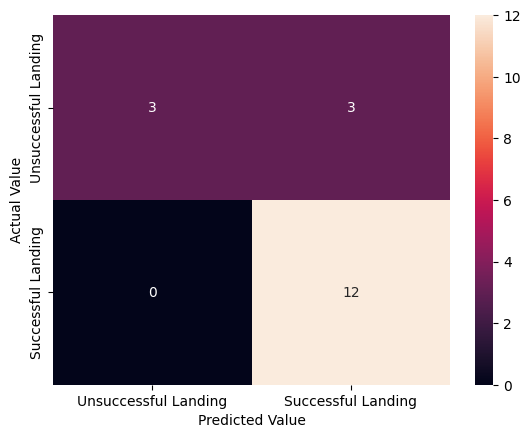

In [123]:
from sklearn.metrics import confusion_matrix
def cm_plot(y,yhat):
    cm = confusion_matrix(y,yhat)
    ax = plt.subplot()
    sns.heatmap(cm,annot=True,ax=ax)
    ax.set_xlabel('Predicted Value')
    ax.set_ylabel('Actual Value')
    ax.xaxis.set_ticklabels(['Unsuccessful Landing','Successful Landing'])
    ax.yaxis.set_ticklabels(['Unsuccessful Landing','Successful Landing'])
    plt.show()

yhat_lr = logreg_cv.predict(X_test)
cm_plot(Y_test,yhat_lr)

Taking a look at the confusion matrix of the model, it seems it can predict successful landings correctly with a high accuracy but we see that the model is prone to producing False positives, i.e. predicting a successful landing when the actual mission outcome is unsuccessful. The model produced 3 False Negatives when tested on the test data.

### *Support Vector Machines (SVM) Model*

In [125]:
from sklearn import svm
svm_parameters = {'kernel':['linear','rbf','poly','sigmoid'], 'C':np.logspace(-3,3,5), 'gamma':np.logspace(-3,3,5)}
svm = svm.SVC()
svm_cv = GridSearchCV(svm,svm_parameters,cv=10,n_jobs=-1)
svm_cv.fit(X_train,Y_train)
svm_accuracy = svm_cv.score(X_test,Y_test)
print("Accuracy of the SVM model on test data : ", svm_accuracy)
print("\nBest Parameters : ", svm_cv.best_params_)
print("Accuracy of the best performing SVM model on training data : ", svm_cv.best_score_)

Accuracy of the SVM model on test data :  0.8888888888888888

Best Parameters :  {'C': 31.622776601683793, 'gamma': 0.03162277660168379, 'kernel': 'sigmoid'}
Accuracy of the best performing SVM model on training data :  0.7553571428571428


The SVM model scores slightly giher than the logistic regression model, predicting with an accuracy of 88.89%.

Plotting the confusion matrix for the model:

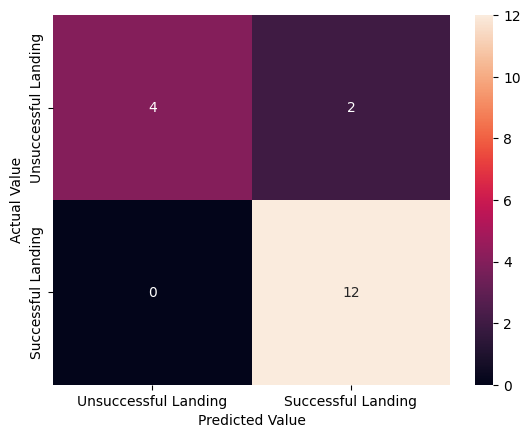

In [124]:
yhat_svm = svm_cv.predict(X_test)
cm_plot(Y_test,yhat_svm)

The SVM model also is prone to False Positives (2 compared to 3), but is slightly less prone to doing so than the Logistic Regression model.

### *Decision Tree Classifier Model*

Accuracy of the Decision Tree Model on test Data :  0.6666666666666666

Best model parameters :  {'criterion': 'entropy', 'max_depth': 12, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 10, 'splitter': 'random'}
Accuracy of the Decision Tree model on training data :  0.7785714285714285


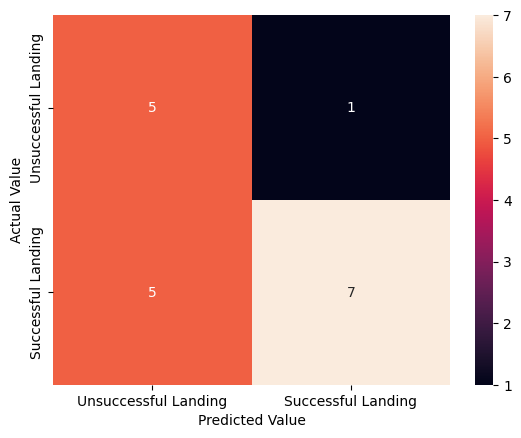

In [131]:
from sklearn.tree import DecisionTreeClassifier
dt_parameters = {'criterion':['gini','entropy'],
                 'splitter':['best','random'],
                 'max_depth':[2*n for n in range(1,10)],
                 'max_features':['log2','sqrt'],
                 'min_samples_leaf':[1,2,4],
                 'min_samples_split':[2,5,10]}
dt = DecisionTreeClassifier()
dt_model = GridSearchCV(dt,dt_parameters,cv=10)
dt_model.fit(X_train,Y_train)
dt_accuracy = dt_model.score(X_test,Y_test)
print("Accuracy of the Decision Tree Model on test Data : ",dt_accuracy)
print("\nBest model parameters : ",dt_model.best_params_)
print("Accuracy of the Decision Tree model on training data : ",dt_model.best_score_)
yhat_dt = dt_model.predict(X_test)
cm_plot(Y_test,yhat_dt)

The Decision Tree algorithm seems to have the lowest accuracy of the models trained so far with 66.67% accuracy predicting landing outcomes from the test data.

The model is prone to producing False Negatives, i.e. tends to predict the mission will have an unsuccessful landing although the mission outcome is successful. It produced 5 False Negatives when tested on the test data. 

### *k-Nearest Neighbors* 

Accuracy of the KNN model on test data :  0.7222222222222222

Best parameters :  {'algorithm': 'auto', 'n_neighbors': 10, 'p': 1}
Accuracy of the best performing KNN model on training data :  0.7392857142857142


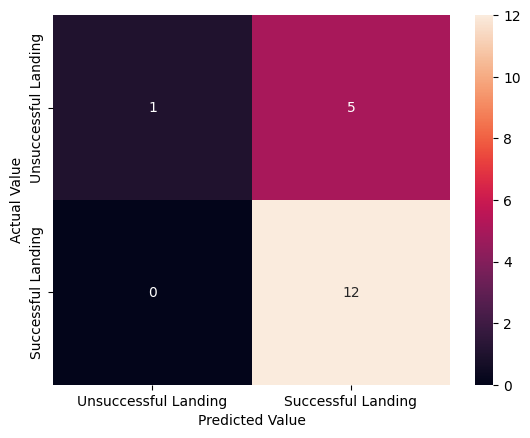

In [134]:
from sklearn.neighbors import KNeighborsClassifier
knn_parameters = {'n_neighbors':[x for x in range(1,11)],
                  'algorithm':['auto','ball_tree','kd_tree','brute'],
                  'p':[1,2]}
knn = KNeighborsClassifier()
knn_cv = GridSearchCV(knn,knn_parameters,cv=10)
knn_cv.fit(X_train,Y_train)
knn_accuracy = knn_cv.score(X_test,Y_test)
print("Accuracy of the KNN model on test data : ", knn_accuracy)
print("\nBest parameters : ", knn_cv.best_params_)
print("Accuracy of the best performing KNN model on training data : ",knn_cv.best_score_)
yhat_knn = knn_cv.predict(X_test)
cm_plot(Y_test,yhat_knn)

The KNN model yields an accuracy of 72.22% and is sligtly more prone to producing False negatives (5 compared to 2) than the SVM model.

## Final Results

,Logistic Regression,Support Vector Machines,Decision Tree Classifier,k-Nearest Neighbors
0,0.833333,0.888889,0.666667,0.722222


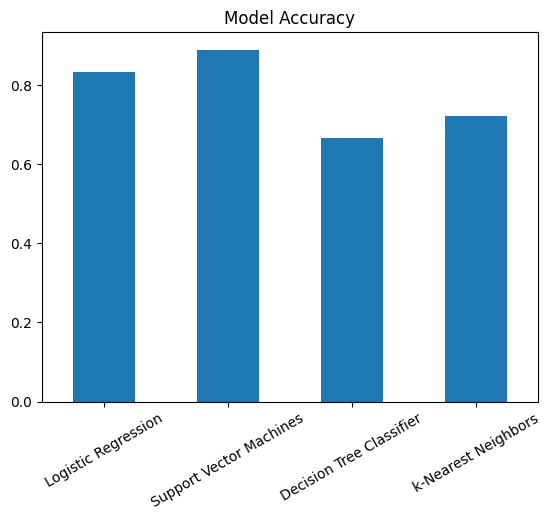

In [147]:
dict = {'Logistic Regression':[logreg_accuracy],
        'Support Vector Machines':[svm_accuracy],
        'Decision Tree Classifier':[dt_accuracy],
        'k-Nearest Neighbors':[knn_accuracy]}
accuracy_table = pd.DataFrame(dict)
accuracy_table.transpose().plot(kind='bar')
plt.xticks(rotation=30)
plt.legend().remove()
plt.title("Model Accuracy")
accuracy_table

The SVM model is found to perform the best with an accuracy of *88.89%* followed by the logistic regression and k-Nearest Neighbors models with accuracies of *83.33%* and *72.22%* respectively. The Decision tree model performed the worst with an accuracy of *66.67%*.

The SVM model is slightly prone to producing False Positives, producing 2 false negatives when used to predict on the test data. The Logistic Regression and k-Nearest Neighbors models are also prone to producing Fasle Positives, predicting 3 and 5 FP's respectively. The Decision Tree classifier model on the other hand is found to be prone to producing False Negatives, producing a total of 5 FN's when used to predict mission outcomes with the test data.

In [148]:
best_model = svm_cv.fit(X,Y)

<code>best_model</code> is the support vector machines ML model that is found to be the most accurate, the SVM model is trained again to include all of the data (training and testing data), to allow it to have the highest accuracy in the future.

## Conclusion

The SpaceX API was used to construct the dataset with historic data of launch parameters and outcomes of previous SpaceX missions. Data of serialized parameters is retrieved and the dataset is completed. The dataset is examined and prepared (or 'cleaned'), ensuring the dataset is numerical and continuous allowing for the training of Machine Learning algorithms. Missing values from the <code>PayloadMass</code> column are replaced with the average payload mass of all missions; categorical variables are converted to dummy/indicator variables using the *get_dummies()* function.

The dataset is then split into a training and testing dataset using sklearn's *train_test_split* function. 80% of the data is used to train the models and 20% is reserved to test for the accuracy/cross-validate the trained models.

Four ML algorithms, namely logistic regression, Support Vector Machines, decision tree classifier and k-Nearest Neighbors are trained and the accuracies of each of the models is calculated. SciKitlearn's *GridSearchCV* function is used to cross-validate the results of the models with 10 folds of the training dataset (cv = 10), find the best hyperparameters and regularization coefficients for the ML algorithms and they are fit to the training data.

The accuracy of the trained models are than evaluated using the testing dataset; the model trained using the Support Vector Machines algorithm is found to perform the best, predicting with a high accuracy of *88.89%* - plotting the confusion matrix, the model is found to be slightly prone to producing False Positives - having produced 2 FP's when cross validated with the test data.

The SVM model can be used to predict with high accuracy if the Falcon 9 rocket will land succesfully or not for future SpaceX missions, given the parameters of the mission.

## Author

Amogha Subramanya